In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),

            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)



class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


# def test():
#     N, in_channels, H, W = 8, 3, 64, 64
#     noise_dim = 100
#     x = torch.randn((N, in_channels, H, W))
#     disc = Discriminator(in_channels, 8)
#     assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
#     gen = Generator(noise_dim, in_channels, 8)
#     z = torch.randn((N, noise_dim, 1, 1))
#     assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


# test()

In [4]:
dis = Discriminator(3, 64)
print(dis)
print("*"*1000)
gen = Generator(100, 3, 64)
print(gen)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (6): 

In [5]:
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64


transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [6]:
dataset = ImageFolder("../input/pkmn-image-dataset/", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
from torchvision.utils import make_grid, save_image
def save_generator_image(image, path):
    save_image(image, path)

In [8]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)

writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

images = []
NUM_EPOCHS = 300
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        epoch += 1
        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real, normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake, normalize=True
                )
                if epoch % 10 == 0:
                    save_generator_image(img_grid_fake, f"./Image_from_epoch_{epoch}.png")
                images.append(img_grid_fake)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                
            step += 1

Epoch [1/300] Batch 0/58                   Loss D: 0.6894, loss G: 0.7802
Epoch [2/300] Batch 0/58                   Loss D: 0.0742, loss G: 2.9988
Epoch [3/300] Batch 0/58                   Loss D: 0.3928, loss G: 1.5713
Epoch [4/300] Batch 0/58                   Loss D: 0.1938, loss G: 1.9808
Epoch [5/300] Batch 0/58                   Loss D: 0.1271, loss G: 2.3028
Epoch [6/300] Batch 0/58                   Loss D: 0.7810, loss G: 1.4190
Epoch [7/300] Batch 0/58                   Loss D: 0.2849, loss G: 2.1335
Epoch [8/300] Batch 0/58                   Loss D: 0.4677, loss G: 1.9050
Epoch [9/300] Batch 0/58                   Loss D: 0.3709, loss G: 1.6746
Epoch [10/300] Batch 0/58                   Loss D: 0.3286, loss G: 2.0462
Epoch [11/300] Batch 0/58                   Loss D: 0.4114, loss G: 1.7676
Epoch [12/300] Batch 0/58                   Loss D: 0.6736, loss G: 2.8642
Epoch [13/300] Batch 0/58                   Loss D: 0.4193, loss G: 2.3062
Epoch [14/300] Batch 0/58         

Epoch [111/300] Batch 0/58                   Loss D: 0.0905, loss G: 4.8153
Epoch [112/300] Batch 0/58                   Loss D: 0.1014, loss G: 4.1706
Epoch [113/300] Batch 0/58                   Loss D: 0.0559, loss G: 4.8710
Epoch [114/300] Batch 0/58                   Loss D: 0.3636, loss G: 7.4500
Epoch [115/300] Batch 0/58                   Loss D: 0.0437, loss G: 4.0175
Epoch [116/300] Batch 0/58                   Loss D: 0.1995, loss G: 5.4809
Epoch [117/300] Batch 0/58                   Loss D: 0.0662, loss G: 4.6726
Epoch [118/300] Batch 0/58                   Loss D: 0.0994, loss G: 3.6864
Epoch [119/300] Batch 0/58                   Loss D: 0.0425, loss G: 4.1356
Epoch [120/300] Batch 0/58                   Loss D: 0.0322, loss G: 4.5521
Epoch [121/300] Batch 0/58                   Loss D: 2.6834, loss G: 8.6531
Epoch [122/300] Batch 0/58                   Loss D: 0.1007, loss G: 3.0225
Epoch [123/300] Batch 0/58                   Loss D: 0.0971, loss G: 5.0196
Epoch [124/3

Epoch [219/300] Batch 0/58                   Loss D: 0.0149, loss G: 5.4485
Epoch [220/300] Batch 0/58                   Loss D: 0.0074, loss G: 6.7786
Epoch [221/300] Batch 0/58                   Loss D: 0.0123, loss G: 6.5229
Epoch [222/300] Batch 0/58                   Loss D: 0.3800, loss G: 8.8803
Epoch [223/300] Batch 0/58                   Loss D: 0.0181, loss G: 5.2688
Epoch [224/300] Batch 0/58                   Loss D: 0.0060, loss G: 9.1557
Epoch [225/300] Batch 0/58                   Loss D: 2.1284, loss G: 11.9293
Epoch [226/300] Batch 0/58                   Loss D: 0.0172, loss G: 5.3129
Epoch [227/300] Batch 0/58                   Loss D: 0.0477, loss G: 5.4855
Epoch [228/300] Batch 0/58                   Loss D: 0.0079, loss G: 5.7362
Epoch [229/300] Batch 0/58                   Loss D: 0.0270, loss G: 4.8951
Epoch [230/300] Batch 0/58                   Loss D: 0.2098, loss G: 3.9166
Epoch [231/300] Batch 0/58                   Loss D: 0.0112, loss G: 5.2199
Epoch [232/

In [9]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in images]

imageio.mimsave('n.gif', imgs)

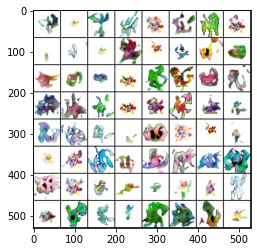

In [13]:
import matplotlib.pyplot as plt
a = plt.imread("./Image_from_epoch_300.png")
plt.imshow(a)

In [14]:
torch.save(gen.state_dict(), 'generatorGAN.pth')

In [12]:
from IPython.display import FileLink
FileLink('./n.gif')

/kaggle/working/n.gif